In [211]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os
#from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
from torch.utils.data import Dataset
import random
from tqdm import tqdm
import json
import threading
import torchvision.transforms.functional as F
from nltk.corpus import wordnet
"""import nltk
nltk.download('omw-1.4')"""

"import nltk\nnltk.download('omw-1.4')"

In [346]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print('No of GPUs i have is',torch.cuda.device_count())
print(torch.cuda.current_device())
print('My Graphic Card is',torch.cuda.get_device_name(torch.cuda.current_device()))
print('Is Cuda Available',torch.cuda.is_available())

cuda
No of GPUs i have is 4
0
My Graphic Card is GeForce GTX 1080 Ti
Is Cuda Available True


In [379]:
class CaptionTransform:
    def __init__(self, replace_p=0.1, delete_p=0.1, swap_p=0.1, shuffle_p=0.1):
        self.replace_p = replace_p
        self.delete_p = delete_p
        self.swap_p = swap_p
        self.shuffle_p = shuffle_p

    def __call__(self, caption):
        caption = self.replace_synonyms(caption)
        caption = self.delete_words(caption)
        caption = self.swap_words(caption)
        caption = self.shuffle_words(caption)
        return caption

    def replace_synonyms(self, caption):
        if random.random() < self.replace_p:
            words = caption.split()
            for i in range(len(words)):
                if random.random() < self.replace_p:
                    synonyms = wordnet.synsets(words[i])
                    if synonyms:
                        replacement = synonyms[0].lemmas()[0].name()
                        words[i] = replacement
            caption = " ".join(words)
        return caption

    def delete_words(self, caption):
        if random.random() < self.delete_p:
            words = caption.split()
            n = int(self.delete_p * len(words))
            indices = random.sample(range(len(words)), n)
            words = [word for i, word in enumerate(words) if i not in indices]
            caption = " ".join(words)
        return caption

    def swap_words(self, caption):
        if random.random() < self.swap_p:
            words = caption.split()
            n = int(self.swap_p * len(words))
            indices = random.sample(range(len(words)), n)
            for i in range(0, n, 2):
                j = min(i+1, n-1)
                words[indices[i]], words[indices[j]] = words[indices[j]], words[indices[i]]
            caption = " ".join(words)
        return caption


    def shuffle_words(self, caption):
        if random.random() < self.shuffle_p:
            words = caption.split()
            random.shuffle(words)
            caption = " ".join(words)
        return caption
class SimCLRData_Caption_Transform:
    def __init__(self, p=0.2):
        self.transform = transforms.Compose([
            CaptionTransform(replace_p=p, delete_p=p, swap_p=p, shuffle_p=p)
        ])
        self.seed = random.randint(0, 2**32 - 1)

    def __call__(self, x):
        random.seed(self.seed)
        return [self.transform(x), self.transform(x)]    

In [412]:
def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([
        rnd_color_jitter,
        transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),
        rnd_gray,
        transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)], p=0.8)])
    return color_distort

class RandomGaussianBlur(object):
    def __init__(self, p=0.5, min_sigma=0.1, max_sigma=2.0):
        self.p = p
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.uniform(self.min_sigma, self.max_sigma)
            kernel_size = int(0.1 * min(img.size))
            kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
            kernel_size = max(1, kernel_size)
            img = F.gaussian_blur(img, kernel_size, [sigma, sigma])
        return img
    
    


size=224
class SimCLRData_image_Transform:
    def __init__(self, size=224):
        s = 1
        size=224
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
            transforms.RandomHorizontalFlip(),
            get_color_distortion(s=1.0),
            RandomGaussianBlur(p=0.5 ,min_sigma=0.1, max_sigma=2.0),
            transforms.ToTensor()
        ])
        self.seed = random.randint(0, 2**32 - 1)

    def __call__(self, x):
        random.seed(self.seed)
        return [self.transform(x), self.transform(x)]
 
    
class FlickrDataset(Dataset):
    def __init__(self, rootdir,data_dir,dataset_type,image_transform=None,caption_transform=None):
        self.image_transform = image_transform
        self.caption_transform = caption_transform
        self.root_dir=rootdir
        self.data_dir = data_dir
        self.image_files = sorted(os.listdir(os.path.join(data_dir)))
        if dataset_type=='train':
            self.caption_file = os.path.join(rootdir, "train_captions.txt")
        elif dataset_type=='test':
            self.caption_file = os.path.join(rootdir, "test_captions.txt")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_files[idx])
        tag = ""
        caption = ""
        with open(self.caption_file, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                if parts[0] == self.image_files[idx]:
                    caption = parts[1]
                    break
        image = Image.open(image_path).convert('RGB')
        
        if self.image_transform:
            img1, img2 = self.image_transform(image)
            
            
        if self.caption_transform:
            caption1, caption2 = self.caption_transform(caption)
            
            
        if self.image_transform and not self.caption_transform:
            return img1, img2,caption
        
        
        if not self.image_transform and  self.caption_transform:
            return imgage,caption1,caption2
        
        elif not self.image_transform and self.caption_transform:
            return image, caption
        
        
        return img1, img2, caption,caption1, caption2

In [413]:
random.seed(42)
# Set the seed for PyTorch's random number generator
torch.manual_seed(42)
simclr_transform = SimCLRDataTransform()
train_dataset = FlickrDataset('data/',"data/train",'train',image_transform=SimCLRData_image_Transform(),
                              caption_transform=SimCLRData_Caption_Transform())
test_dataset = FlickrDataset('data/',"data/test",'test',image_transform=SimCLRData_image_Transform(),
                              caption_transform=SimCLRData_Caption_Transform())
print('length of train',len(train_dataset))
print('length of test',len(test_dataset))
print('total',len(train_dataset)+len(test_dataset))

length of train 4571
length of test 1026
total 5597


  0%|          | 0/5 [00:00<?, ?it/s]

orginal caption: a statue of a man in a black suit
caption1: angstrom statue of a man inch angstrom suit
caption2: a statue of a man inch a black suit


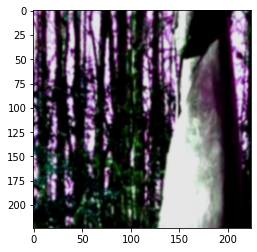

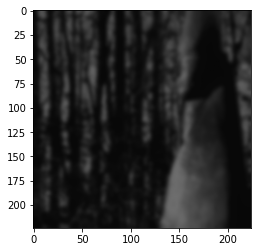

 20%|██        | 1/5 [00:00<00:01,  2.05it/s]

orginal caption: a large amount of colorful objects are in a large room
caption1: angstrom large amount of colorful object are in a large room
caption2: a a amount of colorful objects are in large large room


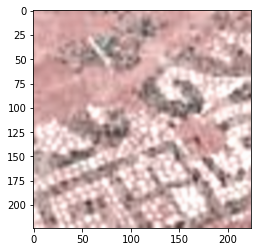

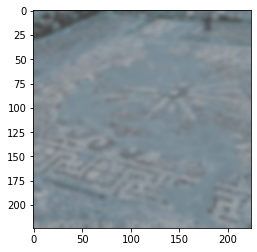

 40%|████      | 2/5 [00:01<00:01,  1.90it/s]

orginal caption: a boat is sitting on the beach
caption1: is boat angstrom on beach the sitting
caption2: a boat is sitting on the beach


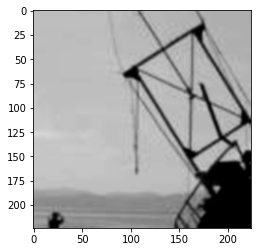

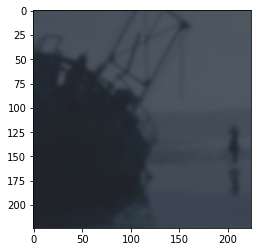

 60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

orginal caption: a beautiful young woman standing on a lush green field
caption1: angstrom beautiful young woman standing on angstrom lush green field
caption2: field woman on lush standing a a young green beautiful


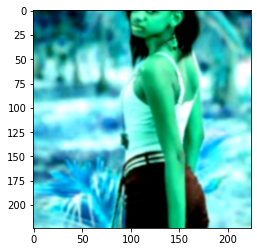

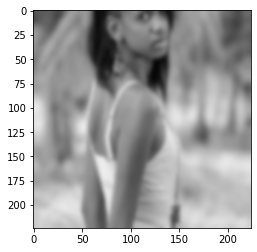

 80%|████████  | 4/5 [00:02<00:00,  1.91it/s]

orginal caption: a road with trees and a road sign
caption1: angstrom road with trees and angstrom road sign
caption2: a road with trees and a road


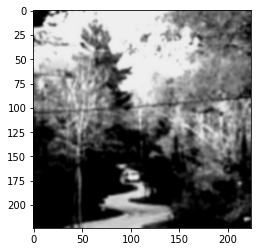

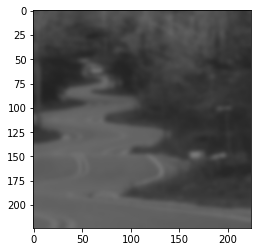

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


In [416]:
# Show original image
for i in tqdm(range(5)):
    img1, img2, caption,caption1, caption2 = test_dataset[i]
    plt.imshow(img1.permute(1, 2, 0))

    # Show augmented image
    plt.figure()
    plt.imshow(img2.permute(1, 2, 0))
    print('orginal caption:',caption)
    print('caption1:',caption1)
    print('caption2:',caption2)
    plt.show()